# <center>***BEEP BOOP Agatha Christie?***</center> 
<center> <img src="https://static.vecteezy.com/system/resources/thumbnails/006/777/102/small_2x/the-mascot-of-cute-ballpoint-as-a-detective-vector.jpg" width=180 height=180 align="center"
 style="float:right;width:4px;height:4px;"></center>
<center>(Gutenberg Sequence-to-Sequence Generator)</center>


### <center>***By Trishla Jain***</center> 

Recurrent Neural Networks can be used as generative models and that is exactly what we will be trying in this notebook. We are using two or more public domain books by Agatha Christie, from Project Gutenberg, to train a sequence-to-sequence model to generate the first page of a non-existent book. We are feeding sentences from several of her books and then demonstrating the capability of our model to generate new sentences.

The notebook follows a pattern of first using "The Mysterious Affair at Styles.txt" to generate text using character-based modeling to generate text (we have first tried to generate only 1000 characters to test our model generation and then once we select our model we will generate 5000 words to get content/words worth calling "page generation"). Throughout the notebook, code has been explained wherever possible or needed. We have used the code and the explanation by Jason Brownlee(mentioned in references section) as a base for our modeling and then built on it. Other than that, I wrote all of the explanatory text and comments in this notebook.

After using one book we have added books "POIROT INVESTIGATES.txt" and "The Murder on the Links.txt" in an attempt to add more data for our model to learn, along with building better LSTM models to reduce our loss and improve our predictions. We have also tried to use a Bidirectional LSTM to see if we can get a better prediction(here we tried to use words rather than characters to generate text). 

I would like to take this opportunity to thank Prof Jeffrey M. Stanton, for helping me throughout the semester with so many of my doubts and for being a mentor in my journey of Applied Data Science be it through videos for Quantitative Reasoning for Data Science or for Natural Language Processing.

In [ ]:
# importing all the necessary libraries for the notebook
import urllib
!pip install nltk
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import pandas as pd
nltk.download('stopwords') 
nltk_stops = nltk.corpus.stopwords.words('english')
import numpy as np
import time
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
import sys
from matplotlib import pyplot as plt
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None


[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# loading the books from Project Gutenberg

## Reading Book 1 - The Mysterious Affair at Styles, by Agatha Christie
# we saved the file to a .txt to remove the headers and footers from the file 
# i.e all the lines before and including -
# *** START OF THE PROJECT GUTENBERG EBOOK THE MYSTERIOUS AFFAIR AT STYLES ***
# and all the lines (after and including the below line)
# *** END OF THE PROJECT GUTENBERG EBOOK THE MYSTERIOUS AFFAIR AT STYLES ***

books_list  = ['The Mysterious Affair at Styles.txt']


def read_lines(books):
    #creating a blank string to store the file text
    global book_text, book_text_lower;
    book_text = ''
    for book_name in books:
        file = open(book_name, 'r')
        for line in file:
            book_text += line
        file.close()
    book_text_lower = book_text.lower()
    return book_text, book_text_lower


read_lines(books_list)

('The Mysterious Affair at Styles\n\nby Agatha Christie\n\nContents\n\n\nCHAPTER I. I GO TO STYLES\nCHAPTER II. THE 16TH AND 17TH OF JULY\nCHAPTER III. THE NIGHT OF THE TRAGEDY\nCHAPTER IV. POIROT INVESTIGATES\nCHAPTER V. “IT ISN’T STRYCHNINE, IS IT?”\nCHAPTER VI. THE INQUEST\nCHAPTER VII. POIROT PAYS HIS DEBTS\nCHAPTER VIII. FRESH SUSPICIONS\nCHAPTER IX. DR. BAUERSTEIN\nCHAPTER X. THE ARREST\nCHAPTER XI. THE CASE FOR THE PROSECUTION\nCHAPTER XII. THE LAST LINK\nCHAPTER XIII. POIROT EXPLAINS\n\n\n\n\nCHAPTER I.\nI GO TO STYLES\n\n\nThe intense interest aroused in the public by what was known at the\ntime as “The Styles Case” has now somewhat subsided. Nevertheless, in\nview of the world-wide notoriety which attended it, I have been asked,\nboth by my friend Poirot and the family themselves, to write an account\nof the whole story. This, we trust, will effectually silence the\nsensational rumours which still persist.\n\nI will therefore briefly set down the circumstances which led to my

In [ ]:
# checking the lenght and type of our book_text variable
print (len(book_text)) # This tells the length of the string in characters
print(type(book_text)) # And this shows the type of the text object.

#checking the first 120 characters of the book 
book_text[:120]

320887
<class 'str'>


'The Mysterious Affair at Styles\n\nby Agatha Christie\n\nContents\n\n\nCHAPTER I. I GO TO STYLES\nCHAPTER II. THE 16TH AND 17TH '

As we can see above, the book *The Mysterious Affair at Styles, by Agatha Christie* has 3320887 lines (with the header and footer the book had 349012 lines and for simplicity the code and the text was removed).  

In [ ]:
# converting the data to lowercase to reduce the vocabulary that the network must learn.
print(book_text_lower[:120])

the mysterious affair at styles

by agatha christie

contents


chapter i. i go to styles
chapter ii. the 16th and 17th 


Since machines cant learn words we will have to convert characters of the english language to integers. We can achieve this by mapping each character to a unique integer.


In [ ]:
# create mapping of unique chars to integers
characters = sorted(list(set(book_text_lower)))
characters_to_int = dict((c, i) for i, c in enumerate(characters))

In [ ]:
list(characters_to_int.items())[30:40]

[('f', 30),
 ('g', 31),
 ('h', 32),
 ('i', 33),
 ('j', 34),
 ('k', 35),
 ('l', 36),
 ('m', 37),
 ('n', 38),
 ('o', 39)]

In [ ]:
# checking how many characters are there in the book and how many are left after
# using set
print(f"Total characters in the book : {len(book_text)} \nTotal characters after set : {len(characters)}")

Total characters in the book : 320887 
Total characters after set : 64


Looks like just making the characters in lower case helped and reduced the character count from 320887 to 64 (previously was 349012 to 73 with header and footer). This will help reduce our training time for our neural network.

Now to actually begin building the model we will keep a variable(lets take it 5 just for example) that will help the network to know how many time steps of one character has to be read to be followed by the output. We are basically sliding along the whole book one character at a time and thus helping the network to understand each character to be learned from the 5 characters that precede it(except the first 5 characters).
Eg: The word being TRISHLA:

```
TRISH -> L
RISHL -> A
```



In [ ]:
# prepare the dataset to have the input and the output along with the number of 
# characters to read, to predict the next character
chars_to_read = 100
dataX = []
dataY = []
for i in range(0, len(book_text_lower) - chars_to_read, 1):
    seq_in = book_text_lower[i:i + chars_to_read]
    seq_out = book_text_lower[i + chars_to_read]
    dataX.append([characters_to_int[char] for char in seq_in])
    dataY.append(characters_to_int[seq_out])
n_patterns = len(dataX)
print(f"Total Patterns: {n_patterns}")

Total Patterns: 320787


As we can see above we got 320787 out of 320887 (this is 100 less; as first 100 characters were excluded).
Now we will transform the list of input sequences into the form [samples, time steps, features] which is required for our LSTM model.

For this, we will first rescale the integers to 0 or 1(since we are using the sigmoid activation function by default) to make patterns easier for our LSTM to learn. Then we will convert the output into a one hot encoding vector so that we can configure the model to predict each of the 73 characters. Each output is converted into a sparse matrix of length 65 where there will be 1 in the column of the character and rest all will be zeros.

Why sigmoid function is used in LSTM?
Sigmoid function is used as the gating function for the three gates (in, out and forget) in LSTM, since it outputs a value between 0 and 1 and it can either let no flow or complete flow of information throughout the gates.

In [ ]:
# reshape X to be [samples, time steps, features]
X = np.reshape(dataX, (n_patterns, chars_to_read, 1))
# normalize
X = X / float(len(characters))
# one hot encode the output variable
y = np_utils.to_categorical(dataY)

In [ ]:
X.shape, y.shape

((320787, 100, 1), (320787, 64))

**Building the LSTM Model**
Below we have defined a single hidden layer LSTM with 256 memory units. The network uses dropout with a probability of 20. The output layer is a Dense Layer using the softmax activation function to output a probability prediction for each of the 47 characters between 0 to 1.
We will be using ADAM optimization algorithm for speed.

In [ ]:
# define the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

There is no test dataset. We are modeling the entire training dataset to learn the probability of each character in a sequence.
Since we are not doing a test train split, we have added a drop out layer which will drop 20% to avoid the model to overfit.

Our model won't be able to predict each character in the training set perfectly which is ok as we are interested in the generalization of the dataset that minimizes the chosen loss function thereby seeking a balance between generalization and overfitting but short of memorization.

Due to limitations of colab (and not using the PRO version) and the fact that the notebook keeps crashing randomly we will use model checkpoint to record all of the network weights to file each time an improvement in loss is observed at the end of each epoch. We will use the best set of weights (lowest loss) to instantiate our generative model.

In [ ]:
# define the checkpoint
filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               264192    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
Total params: 280,640
Trainable params: 280,640
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# defining parameters
epochs = 20
batch_size=128

In [ ]:
start = time.process_time()
history_1 = model.fit(X, y, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list)
print("Total time taken: ", time.process_time() - start)

Epoch 1/20
2507/2507 [==============================] - 107s 42ms/step - loss: 3.0619

Epoch 00001: loss improved from inf to 2.96430, saving model to weights-improvement-01-2.9643.hdf5
Epoch 2/20
2507/2507 [==============================] - 106s 42ms/step - loss: 2.8184

Epoch 00002: loss improved from 2.96430 to 2.79642, saving model to weights-improvement-02-2.7964.hdf5
Epoch 3/20
2507/2507 [==============================] - 106s 42ms/step - loss: 2.7309

Epoch 00003: loss improved from 2.79642 to 2.70812, saving model to weights-improvement-03-2.7081.hdf5
Epoch 4/20
2507/2507 [==============================] - 106s 42ms/step - loss: 2.6471

Epoch 00004: loss improved from 2.70812 to 2.62907, saving model to weights-improvement-04-2.6291.hdf5
Epoch 5/20
2507/2507 [==============================] - 106s 42ms/step - loss: 2.5726

Epoch 00005: loss improved from 2.62907 to 2.56061, saving model to weights-improvement-05-2.5606.hdf5
Epoch 6/20
2507/2507 [==============================] 

## Plotting our Loss 

In [ ]:
def loss_plot(model):
    # Graphing code fragment modified from Rahul Verma on Stackoverflow
    plt.plot(model.history['loss'])
    plt.title('Model History')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Loss'], loc='upper right')
    plt.show()


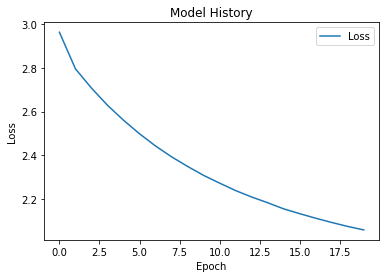

In [ ]:
loss_plot(history_1)

In [ ]:
# since there was no sudden increase in loss as per our graph
# we will check the last loss value fo the model
history_1.history['loss'][-1]

2.0569756031036377

As we can see from the above graph, our model is having a good performance and has reduced loss on every epoch with the final loss being 2.056 and this is only when training on one single book. Post testing how the text generates on this model we will add more books to our dataset to improve our performance even further.


# Generating Text with the LSTM network by loading the data file 

In [ ]:
# load the network weights
def load_weights(file,model):
    filename = file 
    model.load_weights(filename)
    model.compile(loss='categorical_crossentropy', optimizer='adam')


In [ ]:
load_weights("weights-improvement-20-2.0570.hdf5",model)

Converting the integers back to characters so that the final page is in a readable format

In [ ]:
integer_to_characters = dict((i,c) for i, c in enumerate(characters))

In [ ]:
list(integer_to_characters.items())[30], list(characters_to_int.items())[30]


((30, 'f'), ('f', 30))

We were successfully able to get back the characters as shown above.

Now we can go ahead and start making predictions. 
The easiest way to generate predictions is set a seed sequence as input, 
generate the next character then update the seed sequence to add the generated character on the end and trim off the first character. This is repeated till we want to predict new characters(a sequence of 80 or 8000 characters).

We will pick a random input pattern for our seed sequence and then print characters as they are being generated.

In [ ]:
def text_generation(model,characters_to_generate):
  start_time = time.process_time()
  # fetching a random line
  start = np.random.randint(0, len(dataX)-1)
  # set the pattern for the model to predict by starting at the index of the 
  # seed in the original text
  pattern = dataX[start]
  print(f"Seed: {start}")
  # printing the line for reference
  print("\"", ''.join([integer_to_characters[value] for value in pattern]), "\"")
  print("\nBeginning text generation\n")
  # generate the next 1000 or n characters
  for i in range(characters_to_generate):
    # reshaping our array to feed to our model based on the pattern we selected
    # here we are basically checking how long is the pattern which is 100 in our case
    # and we are reshaping it by saying it is a 1D array of length 100
    # eg = pattern = [0,24,32] so after reshape it will be [[0]
    # [24]
    # [32]]. We are basically converting it into a sparse vector
    x = np.reshape(pattern, (1, len(pattern), 1))
    # here we are diving the value say for example the letter which corresponds
    # to integer value 32 and dividing it by 65.0 to get 32/65.0 - 0.492
    x = x / float(len(characters))
    # predicts the possiblity to which character could be next
    prediction = model.predict(x, verbose=0)
    # selects the index of one which has the highest possibility
    index = np.argmax(prediction)
    # store the character into a variable based on the index we got from above
    result = integer_to_characters[index]
    # seq_in is used to store the decoded format of the string that has been 
    # predicted so far
    seq_in = [integer_to_characters[value] for value in pattern]
    sys.stdout.write(result)
    # Here the new string is updated, such that the first character is removed
    # and the new predicted character is included.
    pattern.append(index)
    pattern = pattern[1:len(pattern)]

  print("\nDone.")
  print("Total time taken: ", time.process_time() - start_time)


In [ ]:
text_generation(model,1000)

Seed: 281493
" m, mrs. cavendish was actually in the deceased’s room when the
alarm was given.”

i shot a quick gla "

Beginning text generation

rte tae  and then she was ao interiitllg of the dacl thet ha was a wely oane of the talleg toanee of the fouse. i was aouiet to toent the coor on the house. and then the was ao alliett oo the couoler taat the corr on the hosse. i was aouiet to toent the corr on the soom. 
“io would heve been anlented to toee i aale to toee io the doure to toee io the dour on the fouse.”

“i saee you to toee so to teet it in the courle?”

“yes, sir. i sale ior the toile oo the date th the douoler. ie iad been a ceen oo the fouse of the bouooir that i sas an anlietter. ie was a let woold was to to the coor of the hosse of the fouse oo the saale of the fouse oo the saale of the fouse oo the saale. 
“io whu soaerstand that i sas io the coirert of the fouse of the fouse of the fouse of the bouooir. ie was a wely oane of the talled toanee to the dour on the sale oo

As we can see above, most of the other words seem gibberish and there are alot of spelling mistakes. We will need to make a better model to make sense of the words that the LSTM generates  

In [ ]:
model_2 = Sequential()
model_2.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model_2.add(Dropout(0.2))
model_2.add(LSTM(256))
model_2.add(Dropout(0.2))
model_2.add(Dense(y.shape[1], activation='softmax'))
model_2.compile(loss='categorical_crossentropy', optimizer='adam')
filepath="weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"

We have added another layer and dropout to our new model and will also increase the number of training epochs from 20 to 50 and decrease the batch size from 128 to 64 to give the network more of an opportunity to be updated and learn.

In [ ]:
# defining parameters
epochs = 50
batch_size=64


In [ ]:
start_time = time.process_time()
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
# fit the model
history_2 = model_2.fit(X, y, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list)
print(f"Total time taken: {time.process_time() - start_time}")

Epoch 1/50
5013/5013 [==============================] - 322s 63ms/step - loss: 3.1002

Epoch 00001: loss improved from inf to 3.08712, saving model to weights-improvement-01-3.0871-bigger.hdf5
Epoch 2/50
5013/5013 [==============================] - 317s 63ms/step - loss: 2.8796

Epoch 00002: loss improved from 3.08712 to 2.77053, saving model to weights-improvement-02-2.7705-bigger.hdf5
Epoch 3/50
5013/5013 [==============================] - 319s 64ms/step - loss: 2.5709

Epoch 00003: loss improved from 2.77053 to 2.52134, saving model to weights-improvement-03-2.5213-bigger.hdf5
Epoch 4/50
5013/5013 [==============================] - 320s 64ms/step - loss: 2.3807

Epoch 00004: loss improved from 2.52134 to 2.36095, saving model to weights-improvement-04-2.3610-bigger.hdf5
Epoch 5/50
5013/5013 [==============================] - 320s 64ms/step - loss: 2.2454

Epoch 00005: loss improved from 2.36095 to 2.22098, saving model to weights-improvement-05-2.2210-bigger.hdf5
Epoch 6/50
5013/501

## Plotting our Loss

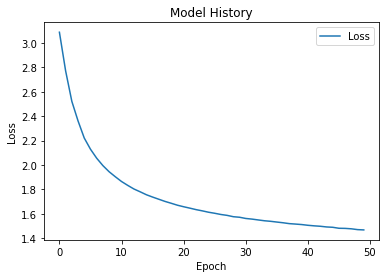

In [ ]:
loss_plot(history_2)

In [ ]:
history_2.history['loss'][-1]

1.4689050912857056

As we can see from the above graph, our model is having a good performance and has reduced loss on every epoch with the final loss being 1.468 and this is only when training on one single book. 


In [ ]:
# loading the model with bigger weights and generating text
load_weights("weights-improvement-50-1.4689-bigger.hdf5",model_2)
text_generation(model_2,1000)

Seed: 244810
" sing; and, as you know, i
do not like confusion.”

before i could reply, one of the other belgians o "

Beginning text generation

f the door of the coor of the coor of the coor of the coor. 
“what do you mean?”

“no. iohn,” i said at last, “i shought you were an overdeale of the door.”

“i do not see her for the soom of the door of the coor. i have not tell you that it was the coorents of the coor.
the man was a lot of parers. the man was a lady in the way, and the coor of the coor of the coor of the coor and she had been an accouitning of the door.

“what do you mean?”

“no. iohn,” i said at last, “i shought you were an overdeale of the door.”

“i do not see her for the soom of the door of the coor. i have not tell you that it was the coorents of the coor.
the man was a lot of parers. the man was a lady in the way, and the coor of the coor of the coor of the coor and she had been an accouitning of the door.

“what do you mean?”

“no. iohn,” i said at last, “i shought y

The bigger weights model did a far better job at generating words that make sense over the last model.
To make our model better we will try adding two more books and adding more layers to the model and tuning the hyper paramaters.

In [ ]:
books_list  = ['The Mysterious Affair at Styles.txt',
              'POIROT INVESTIGATES.txt']

read_lines(books_list)

("The Mysterious Affair at Styles\n\nby Agatha Christie\n\nContents\n\n\nCHAPTER I. I GO TO STYLES\nCHAPTER II. THE 16TH AND 17TH OF JULY\nCHAPTER III. THE NIGHT OF THE TRAGEDY\nCHAPTER IV. POIROT INVESTIGATES\nCHAPTER V. “IT ISN’T STRYCHNINE, IS IT?”\nCHAPTER VI. THE INQUEST\nCHAPTER VII. POIROT PAYS HIS DEBTS\nCHAPTER VIII. FRESH SUSPICIONS\nCHAPTER IX. DR. BAUERSTEIN\nCHAPTER X. THE ARREST\nCHAPTER XI. THE CASE FOR THE PROSECUTION\nCHAPTER XII. THE LAST LINK\nCHAPTER XIII. POIROT EXPLAINS\n\n\n\n\nCHAPTER I.\nI GO TO STYLES\n\n\nThe intense interest aroused in the public by what was known at the\ntime as “The Styles Case” has now somewhat subsided. Nevertheless, in\nview of the world-wide notoriety which attended it, I have been asked,\nboth by my friend Poirot and the family themselves, to write an account\nof the whole story. This, we trust, will effectually silence the\nsensational rumours which still persist.\n\nI will therefore briefly set down the circumstances which led to my

We will generate the same LSTM model we did previously and see if we can get a loss less than 1.46 and then go ahead and build a even bigger model.

In [ ]:
# resetting the variables to point to the new input

# checking the lenght and type of our book_text variable
print (len(book_text)) # This tells the length of the string in characters
print(type(book_text)) # And this shows the type of the emmatext object.

#checking the first 120 characters of the book 
print(book_text[:200])
# create mapping of unique chars to integers
characters = sorted(list(set(book_text_lower)))
characters_to_int = dict((c, i) for i, c in enumerate(characters))
# checking how many characters are there in the book and how many are left after
# using set
print(f"Total characters in the book : {len(book_text)} \nTotal characters after set : {len(characters)}")
# prepare the dataset of have the input and the output along with the number of 
# characters to read to predict the next character
chars_to_read = 100
dataX = []
dataY = []
for i in range(0, len(book_text_lower) - chars_to_read, 1):
	seq_in = book_text_lower[i:i + chars_to_read]
	seq_out = book_text_lower[i + chars_to_read]
	dataX.append([characters_to_int[char] for char in seq_in])
	dataY.append(characters_to_int[seq_out])
n_patterns = len(dataX)
print(f"Total Patterns: {n_patterns}")
# reshape X to be [samples, time steps, features]
X = np.reshape(dataX, (n_patterns, chars_to_read, 1))
# normalize
X = X / float(len(characters))
# one hot encode the output variable
y = np_utils.to_categorical(dataY)
print(X.shape, y.shape)

617691
<class 'str'>
The Mysterious Affair at Styles

by Agatha Christie

Contents


CHAPTER I. I GO TO STYLES
CHAPTER II. THE 16TH AND 17TH OF JULY
CHAPTER III. THE NIGHT OF THE TRAGEDY
CHAPTER IV. POIROT INVESTIGATES
CH
Total characters in the book : 617691 
Total characters after set : 70
Total Patterns: 617591
(617591, 100, 1) (617591, 70)


We can see that the number of characters have increased to 617691 from 320887 and total characters after set have increased to 70 from 64.

In [ ]:
model_3 = Sequential()
model_3.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model_3.add(Dropout(0.2))
model_3.add(LSTM(256))
model_3.add(Dropout(0.2))
model_3.add(Dense(y.shape[1], activation='softmax'))
model_3.compile(loss='categorical_crossentropy', optimizer='adam')
filepath="weights-improvement-{epoch:02d}-{loss:.4f}-bigger_v2.hdf5"
print(model_3.summary())
epochs = 50
batch_size = 28

start_time = time.process_time()
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
# fit the model
history_3 = model_3.fit(X, y, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list)
print(f"Total time taken: {time.process_time() - start_time}")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 256)          264192    
_________________________________________________________________
dropout (Dropout)            (None, 100, 256)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 70)                17990     
Total params: 807,494
Trainable params: 807,494
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
22057/22057 [==============================] - 949s 42ms/step - loss: 2.7717

Epoch 00001: loss impr

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19108/22057 [========================>.....] - ETA: 2:03 - loss: 1.4432

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22057/22057 [==============================] - 930s 42ms/step - loss: 1.4357

Epoch 00042: loss improved from 1.45110 to 1.44850, saving model to weights-improvement-42-1.4485-bigger_v2.hdf5
Epoch 43/50
22057/22057 [==============================] - 929s 42ms/step - loss: 1.4368

Epoch 00043: loss improved from 1.44850 to 1.44366, saving model to weights-improvement-43-1.4437-bigger_v2.hdf5
Epoch 44/50
22057/22057 [==============================] - 928s 42ms/step - loss: 1.4373

Epoch 00044: loss did not improve from 1.44366
Epoch 45/50
22057/22057 [==============================] - 930s 42ms/step - loss: 1.4603

Epoch 00045: loss did not improve from 1.44366
Epoch 46/50
22057/22057 [==============================] - 927s 42ms/step - loss: 1.4233

Epoch 00046: loss improved from 1.44366 to 1.43136, saving model to weights-improvement-46-1.4314-bigger_v2.hdf5
Epoch 47/50
22057/22057 [==============================] - 929s 42ms/step - loss: 1.4227

Epoch 00047: loss improved from 1.43136

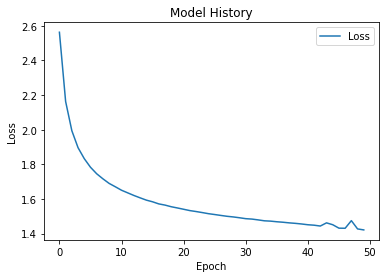

1.421240210533142


In [ ]:
loss_plot(history_3)
print(history_3.history['loss'][-1])

The loss improved a bit (reduced from 1.46 to 1.421). We will now try adding another book and reduced the chars_to_read from 100 to 5 and see if we can get a loss less than 1.42

In [ ]:
books_list  = ['The Mysterious Affair at Styles.txt',
              'POIROT INVESTIGATES.txt',
              'The Murder on the Links.txt']

read_lines(books_list)

("The Mysterious Affair at Styles\n\nby Agatha Christie\n\nContents\n\n\nCHAPTER I. I GO TO STYLES\nCHAPTER II. THE 16TH AND 17TH OF JULY\nCHAPTER III. THE NIGHT OF THE TRAGEDY\nCHAPTER IV. POIROT INVESTIGATES\nCHAPTER V. “IT ISN’T STRYCHNINE, IS IT?”\nCHAPTER VI. THE INQUEST\nCHAPTER VII. POIROT PAYS HIS DEBTS\nCHAPTER VIII. FRESH SUSPICIONS\nCHAPTER IX. DR. BAUERSTEIN\nCHAPTER X. THE ARREST\nCHAPTER XI. THE CASE FOR THE PROSECUTION\nCHAPTER XII. THE LAST LINK\nCHAPTER XIII. POIROT EXPLAINS\n\n\n\n\nCHAPTER I.\nI GO TO STYLES\n\n\nThe intense interest aroused in the public by what was known at the\ntime as “The Styles Case” has now somewhat subsided. Nevertheless, in\nview of the world-wide notoriety which attended it, I have been asked,\nboth by my friend Poirot and the family themselves, to write an account\nof the whole story. This, we trust, will effectually silence the\nsensational rumours which still persist.\n\nI will therefore briefly set down the circumstances which led to my

In [ ]:
# checking the lenght and type of our book_text variable
print (len(book_text)) # This tells the length of the string in characters
print(type(book_text)) # And this shows the type of the emmatext object.

#checking the first 120 characters of the book 
print(book_text[:200])
# create mapping of unique chars to integers
characters = sorted(list(set(book_text_lower)))
characters_to_int = dict((c, i) for i, c in enumerate(characters))
# checking how many characters are there in the book and how many are left after
# using set
print(f"Total characters in the book : {len(book_text)} \nTotal characters after set : {len(characters)}")
# prepare the dataset of have the input and the output along with the number of 
# characters to read to predict the next character
chars_to_read = 5
dataX = []
dataY = []
for i in range(0, len(book_text_lower) - chars_to_read, 1):
	seq_in = book_text_lower[i:i + chars_to_read]
	seq_out = book_text_lower[i + chars_to_read]
	dataX.append([characters_to_int[char] for char in seq_in])
	dataY.append(characters_to_int[seq_out])
n_patterns = len(dataX)
print(f"Total Patterns: {n_patterns}")
# reshape X to be [samples, time steps, features]
X = np.reshape(dataX, (n_patterns, chars_to_read, 1))
# normalize
X = X / float(len(characters))
# one hot encode the output variable
y = np_utils.to_categorical(dataY)
print(X.shape, y.shape)

981001
<class 'str'>
The Mysterious Affair at Styles

by Agatha Christie

Contents


CHAPTER I. I GO TO STYLES
CHAPTER II. THE 16TH AND 17TH OF JULY
CHAPTER III. THE NIGHT OF THE TRAGEDY
CHAPTER IV. POIROT INVESTIGATES
CH
Total characters in the book : 981001 
Total characters after set : 75
Total Patterns: 980996
(980996, 5, 1) (980996, 75)


We can see that the number of characters have increased to 981001 from 617691  and total characters after set have increased to 75 from 70.

In [ ]:
model_4 = Sequential()
model_4.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model_4.add(Dropout(0.2))
model_4.add(LSTM(256))
model_4.add(Dropout(0.2))
model_4.add(Dense(y.shape[1], activation='softmax'))
model_4.compile(loss='categorical_crossentropy', optimizer='adam')

print(model_4.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 5, 256)            264192    
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 256)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 75)                19275     
Total params: 808,779
Trainable params: 808,779
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
epochs = 100
batch_size = 50#50
filepath="weights-improvement-{epoch:02d}-{loss:.4f}-gigantic.hdf5"
start_time = time.process_time()
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
# fit the model
history_4 = model_4.fit(X, y, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list)
print(f"Total time taken: {time.process_time() - start_time}")

Epoch 1/100
19620/19620 [==============================] - 239s 12ms/step - loss: 2.7204

Epoch 00001: loss improved from inf to 2.50922, saving model to weights-improvement-01-2.5092-gigantic.hdf5
Epoch 2/100
19620/19620 [==============================] - 236s 12ms/step - loss: 2.1897

Epoch 00002: loss improved from 2.50922 to 2.13670, saving model to weights-improvement-02-2.1367-gigantic.hdf5
Epoch 3/100
19620/19620 [==============================] - 235s 12ms/step - loss: 2.0160

Epoch 00003: loss improved from 2.13670 to 1.99031, saving model to weights-improvement-03-1.9903-gigantic.hdf5
Epoch 4/100
19620/19620 [==============================] - 237s 12ms/step - loss: 1.9221

Epoch 00004: loss improved from 1.99031 to 1.90680, saving model to weights-improvement-04-1.9068-gigantic.hdf5
Epoch 5/100
19620/19620 [==============================] - 235s 12ms/step - loss: 1.8569

Epoch 00005: loss improved from 1.90680 to 1.84947, saving model to weights-improvement-05-1.8495-gigantic

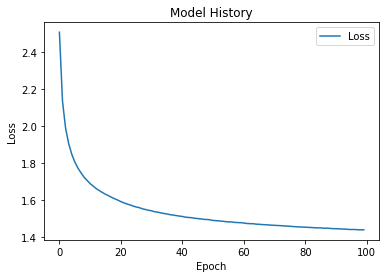

1.43964421749115


In [ ]:
loss_plot(history_4)
print(history_4.history['loss'][-1])

We didn't get a loss lesser than 1.42 so we will try to build a bigger model



In [ ]:
model_5 = Sequential()
model_5.add(LSTM(500, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model_5.add(Dropout(0.2))
model_5.add(LSTM(500, return_sequences=True))
model_5.add(Dropout(0.2))
model_5.add(LSTM(500))
model_5.add(Dropout(0.2))
model_5.add(Dense(y.shape[1], activation='softmax'))

model_5.compile(loss='categorical_crossentropy', optimizer='adam')
model_5.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 500)          1004000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 500)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 500)          2002000   
_________________________________________________________________
dropout_4 (Dropout)          (None, 100, 500)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 500)               2002000   
_________________________________________________________________
dropout_5 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 75)               

In [ ]:
epochs = 50
batch_size = 50#50
filepath="weights-improvement-{epoch:02d}-{loss:.4f}-gigantic_v2.hdf5"
start_time = time.process_time()
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
# fit the model
history_5 = model_5.fit(X, y, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list)
print(f"Total time taken: {time.process_time() - start_time}")

Epoch 1/50
19620/19620 [==============================] - 528s 27ms/step - loss: 2.5658

Epoch 00001: loss improved from inf to 2.27385, saving model to weights-improvement-01-2.2738-gigantic_v2.hdf5
Epoch 2/50
19620/19620 [==============================] - 521s 27ms/step - loss: 1.8911

Epoch 00002: loss improved from 2.27385 to 1.84964, saving model to weights-improvement-02-1.8496-gigantic_v2.hdf5
Epoch 3/50
19620/19620 [==============================] - 521s 27ms/step - loss: 1.7399

Epoch 00003: loss improved from 1.84964 to 1.72410, saving model to weights-improvement-03-1.7241-gigantic_v2.hdf5
Epoch 4/50
19620/19620 [==============================] - 522s 27ms/step - loss: 1.6586

Epoch 00004: loss improved from 1.72410 to 1.64953, saving model to weights-improvement-04-1.6495-gigantic_v2.hdf5
Epoch 5/50
19620/19620 [==============================] - 521s 27ms/step - loss: 1.6044

Epoch 00005: loss improved from 1.64953 to 1.60034, saving model to weights-improvement-05-1.6003-g

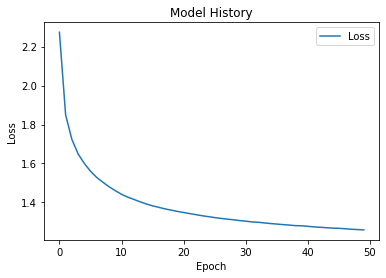

1.2586452960968018


In [ ]:
loss_plot(history_5)
print(history_5.history['loss'][-1])

The loss reduced to 1.258 which is great. We will now generate text and see if it makes sense 

In [ ]:
load_weights("weights-improvement-50-1.2586-gigantic_v2.hdf5",model_5)
integer_to_characters = dict((i,c) for i, c in enumerate(characters))
list(integer_to_characters.items())[30], list(characters_to_int.items())[30]
text_generation(model_5,1000)

Seed: 540618
"  one  "

Beginning text generation

of the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the starte

The spelling is correct but the same word is getting repeated, it is possible it is due to the fact that we set chars_to_read as only 5, we will reset it to 100 and then retrain the model (with the same architecture) and see how it performs

In [ ]:
# checking the lenght and type of our book_text variable
print (len(book_text)) # This tells the length of the string in characters
print(type(book_text)) # And this shows the type of the emmatext object.

#checking the first 120 characters of the book 
print(book_text[:200])
# create mapping of unique chars to integers
characters = sorted(list(set(book_text_lower)))
characters_to_int = dict((c, i) for i, c in enumerate(characters))
# checking how many characters are there in the book and how many are left after
# using set
print(f"Total characters in the book : {len(book_text)} \nTotal characters after set : {len(characters)}")
# prepare the dataset of have the input and the output along with the number of 
# characters to read to predict the next character
chars_to_read = 100
dataX = []
dataY = []
for i in range(0, len(book_text_lower) - chars_to_read, 1):
	seq_in = book_text_lower[i:i + chars_to_read]
	seq_out = book_text_lower[i + chars_to_read]
	dataX.append([characters_to_int[char] for char in seq_in])
	dataY.append(characters_to_int[seq_out])
n_patterns = len(dataX)
print(f"Total Patterns: {n_patterns}")
# reshape X to be [samples, time steps, features]
X = np.reshape(dataX, (n_patterns, chars_to_read, 1))
# normalize
X = X / float(len(characters))
# one hot encode the output variable
y = np_utils.to_categorical(dataY)
print(X.shape, y.shape)

981001
<class 'str'>
The Mysterious Affair at Styles

by Agatha Christie

Contents


CHAPTER I. I GO TO STYLES
CHAPTER II. THE 16TH AND 17TH OF JULY
CHAPTER III. THE NIGHT OF THE TRAGEDY
CHAPTER IV. POIROT INVESTIGATES
CH
Total characters in the book : 981001 
Total characters after set : 75
Total Patterns: 980901
(980901, 100, 1) (980901, 75)


In [ ]:
epochs = 20
batch_size = 100#50
filepath="weights-improvement-{epoch:02d}-{loss:.4f}-gigantic_v3.hdf5"
start_time = time.process_time()
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
# fit the model
history_6 = model_5.fit(X, y, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list)
print(f"Total time taken: {time.process_time() - start_time}")

Epoch 1/20
9810/9810 [==============================] - 4108s 419ms/step - loss: 2.3052

Epoch 00001: loss improved from inf to 2.30523, saving model to weights-improvement-01-2.3052-gigantic_v3.hdf5
Epoch 2/20
4140/9810 [===========>..................] - ETA: 39:54 - loss: 1.8358

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



9810/9810 [==============================] - 4142s 422ms/step - loss: 1.7776

Epoch 00002: loss improved from 2.30523 to 1.77755, saving model to weights-improvement-02-1.7776-gigantic_v3.hdf5
Epoch 3/20
 798/9810 [=>............................] - ETA: 1:03:20 - loss: 1.6539

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



7332/9810 [=====================>........] - ETA: 17:25 - loss: 1.6301

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4106/9810 [===========>..................] - ETA: 40:08 - loss: 1.5459

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



9810/9810 [==============================] - 4142s 422ms/step - loss: 1.5385

Epoch 00004: loss improved from 1.62344 to 1.53851, saving model to weights-improvement-04-1.5385-gigantic_v3.hdf5
Epoch 5/20
 642/9810 [>.............................] - ETA: 1:04:31 - loss: 1.4946

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



9810/9810 [==============================] - 4145s 423ms/step - loss: 1.4833

Epoch 00005: loss improved from 1.53851 to 1.48330, saving model to weights-improvement-05-1.4833-gigantic_v3.hdf5
Epoch 6/20
9810/9810 [==============================] - 4150s 423ms/step - loss: 1.4400

Epoch 00006: loss improved from 1.48330 to 1.44001, saving model to weights-improvement-06-1.4400-gigantic_v3.hdf5
Epoch 7/20
4073/9810 [===========>..................] - ETA: 40:27 - loss: 1.4037

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



9810/9810 [==============================] - 4151s 423ms/step - loss: 1.4063

Epoch 00007: loss improved from 1.44001 to 1.40629, saving model to weights-improvement-07-1.4063-gigantic_v3.hdf5
Epoch 8/20
9810/9810 [==============================] - 4150s 423ms/step - loss: 1.3778

Epoch 00008: loss improved from 1.40629 to 1.37783, saving model to weights-improvement-08-1.3778-gigantic_v3.hdf5
Epoch 9/20
9810/9810 [==============================] - 4152s 423ms/step - loss: 1.3548

Epoch 00009: loss improved from 1.37783 to 1.35478, saving model to weights-improvement-09-1.3548-gigantic_v3.hdf5
Epoch 10/20
9810/9810 [==============================] - 4151s 423ms/step - loss: 1.3365

Epoch 00010: loss improved from 1.35478 to 1.33654, saving model to weights-improvement-10-1.3365-gigantic_v3.hdf5
Epoch 11/20
9810/9810 [==============================] - 4151s 423ms/step - loss: 1.3184

Epoch 00011: loss improved from 1.33654 to 1.31837, saving model to weights-improvement-11-1.3184-gigant

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



9810/9810 [==============================] - 4153s 423ms/step - loss: 1.2907

Epoch 00013: loss improved from 1.30375 to 1.29069, saving model to weights-improvement-13-1.2907-gigantic_v3.hdf5
Epoch 14/20
9810/9810 [==============================] - 4154s 423ms/step - loss: 1.2787

Epoch 00014: loss improved from 1.29069 to 1.27868, saving model to weights-improvement-14-1.2787-gigantic_v3.hdf5
Epoch 15/20
9810/9810 [==============================] - 4158s 424ms/step - loss: 1.2684

Epoch 00015: loss improved from 1.27868 to 1.26845, saving model to weights-improvement-15-1.2684-gigantic_v3.hdf5
Epoch 16/20
9810/9810 [==============================] - 4160s 424ms/step - loss: 1.2568

Epoch 00016: loss improved from 1.26845 to 1.25677, saving model to weights-improvement-16-1.2568-gigantic_v3.hdf5
Epoch 17/20
9810/9810 [==============================] - 4155s 424ms/step - loss: 1.2485

Epoch 00017: loss improved from 1.25677 to 1.24852, saving model to weights-improvement-17-1.2485-giga

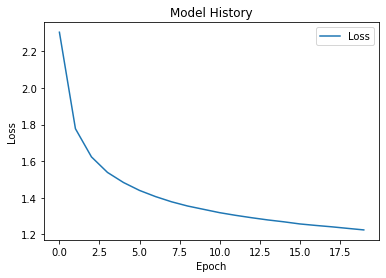

1.2239958047866821


In [ ]:
loss_plot(history_6)
print(history_6.history['loss'][-1])

The loss reduced to 1.22 which is the lowest we have achieved so far and the model is same as model 5 with chars_to_read as 100 characters. Now we will generate text to see if the text makes sense.

In [ ]:
load_weights("weights-improvement-20-1.2240-gigantic_v3.hdf5",model_5)
integer_to_characters = dict((i,c) for i, c in enumerate(characters))
list(integer_to_characters.items())[30], list(characters_to_int.items())[30]
text_generation(model_5,1000)

Seed: 975822
" ubt very much if the police will ever find her.”

“has jack renauld been—told?”

“not yet.”

“it wil "

Beginning text generation

l be a man of the story of the man who had been a considerable sense of the story of the man who had been a sentence of the start of the man who had been a sentence of the start of the man who had been a sentence of the start of the man who had been a sentence of the start of the man who had been a sentence of the start of the man who had been a sentence of the start of the man who had been a sentence of the start of the man who had been a sentence of the start of the man who had been a sentence of the start of the man who had been a sentence of the start of the man who had been a sentence of the start of the man who had been a sentence of the start of the man who had been a sentence of the start of the man who had been a sentence of the start of the man who had been a sentence of the start of the man who had been a sentence of the start of t

We tried character based models (tried 5 different one of them) and despite reducing the loss to 1.2 our model generated text which didn't make a lot of sense and ended up repeating words such as "sentence" and "man".
Although we did improve on getting the spellings right finally as compared to our model 1. All this was just 1000 characters and we are assuming that there would atleast be 5000 characters for a page of a novel. 

Now we will try to use a Bidirectional LSTM using words to predict rather than characters and see if we can improve our predictions. (The below code has to be run on Kaggle as on JupyterHub we kept getting the error "The kernel appears to have died. It will restart automatically." so the output of that code and model is attached in a seperate ipynb and below is just the code skeleton of it.)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np

In [ ]:
tokenizer = Tokenizer()

corpus = book_text_lower.split("\n")
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1
print(f"Total tokenized words are: {total_words}")

Total tokenized words are: 12295


In [ ]:
list(tokenizer.word_index.items())[0:10]

[('the', 1),
 ('”', 2),
 ('to', 3),
 ('i', 4),
 ('of', 5),
 ('a', 6),
 ('and', 7),
 ('was', 8),
 ('that', 9),
 ('it', 10)]

In [ ]:
# create input sequences using list of tokens
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

In [ ]:
input_sequences[0:5]

[[1, 689],
 [1, 689, 396],
 [1, 689, 396, 21],
 [1, 689, 396, 21, 384],
 [40, 2664]]

In [ ]:
# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

In [ ]:
# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [ ]:
model_6 = Sequential()
model_6.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model_6.add(Bidirectional(LSTM(150, return_sequences = True)))
model_6.add(Dropout(0.2))
model_6.add(LSTM(100))
model_6.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_6.add(Dense(total_words, activation='softmax'))
model_6.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_6.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 18, 100)           1229500   
_________________________________________________________________
bidirectional (Bidirectional (None, 18, 300)           301200    
_________________________________________________________________
dropout (Dropout)            (None, 18, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 6147)              620847    
_________________________________________________________________
dense_1 (Dense)              (None, 12295)             75589660  
Total params: 77,901,607
Trainable params: 77,901,607
Non-trainable params: 0
____________________________________________

In [ ]:
history_7 = model_6.fit(predictors, label, epochs=100, verbose=1)

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()
plt.show()

In [ ]:
seed_text = "The original dagger was"
next_words = 1000

In [ ]:
print("\nBeginning text generation\n")
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predict_x = model_6.predict(token_list)
    predicted = np.argmax(predict_x, axis=1)
    #predicted = model_6.predict_classes(token_list, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)
print("\nText Generation Done!\n")

# Conclusion
We first removed the header and footer of books which we extracted from the Gutenberg website. Then we extracted the book, made it lower case (to reduce the number of characters for our model to learn), and broke down the words into characters and took a set of it to remove duplicates. We then created a different models to train our data by changing the input lengths - (the number of books we used to train) and how many characters we used to train the model on, the batch size and epochs. Due to limitations of colab/kaggle and Juypterhub, the notebook kept crashing randomly so we used model checkpoint to record all of the network weights to file each time an improvement in loss was observed at the end of each epoch. We used the best set of weights (lowest loss) to instantiate our generative model. Eventually, we saw that using character generated models can't really make good predictions and despite constantly reducing the loss, the predictions didn't really make sense. Then we moved on to create a model that was trained on words rather than characters and despite having a loss of 3.35, the data predicted by our model was far better.The only shortcoming of the model was that it didn't capitalize proper nouns (which it couldn't learn as we made all the words lower case before tokenizing) and if we had more compute capability(probably purchasing pro version for RAM, CPU and GPU) we could work on making a better model which would make sentences that not only make sense but also follow all the grammatical rules that exist in the English language. All the models saw that the loss was reducing with each epoch which was good and we were sure that there is no overfitting in our models.

Below is a table that has summarized all the models results:

|Number of books used | Chars to read to train | Model | Loss | Results Generated interpretation |
| --- | --- | --- | --- | --- |
|1| 100| Basic LSTM Model (Model 1) | 2.05697 | Gibberish results with spelling errors |
|1| 100| 2x of a layer of 256 LSTM cells the dropout (20%) (Model 2) | 1.4689 | Few words generated were correct both grammatically and without spelling errors but the ratio of such words was low|
|2| 100| 2x of a layer of 256 LSTM cells the dropout (20%) (Model 3) | 1.4212 | Wasn't generated as the loss didn't really reduce from the previous model |
|3| 100| 2x of a layer of 256 LSTM cells the dropout (20%) (Model 4) | 1.439 | Wasn't generated as the loss didn't really reduce from the previous model |
|3| 5 | 3x of a layer of 500 LSTM cells the dropout (20%) (Model 5) | 1.2586 | The model generated "the started" again and again as the chars_to_read were set to 5 |
|3| 100| 3x of a layer of 500 LSTM cells the dropout (20%) (Model 6) | 1.2239 | The model generated the best results so far with least amount of spelling errors but after one line started repeating "start of the man who had been a sentence of the" again and again|
|3| NA | Bidirectional LSTM of 150 cells + 100 LSTM cell with dropout (20%) (Model 7) | 3.3534 | The model generated the best result without spelling mistakes and avoided repeating words/sequences |


**References:**

1) Image - https://www.vecteezy.com/vector-art/6777102-the-mascot-of-cute-ballpoint-as-a-detective

2) https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/

3) https://stackoverflow.com/questions/40761185/what-is-the-intuition-of-using-tanh-in-lstm

4) https://www.analyticsvidhya.com/blog/2018/03/text-generation-using-python-nlp/

5) https://github.com/pranjal52/text_generators/blob/master/a_gigantic_model.ipynb

6) https://towardsdatascience.com/nlp-text-generation-through-bidirectional-lstm-model-9af29da4e520